In [1]:
import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
import tensorflow as tf
import keras

df = pd.read_csv('../input/feedback-prize-2021/train.csv')
df[['discourse_id', 'discourse_start', 'discourse_end']] = df[['discourse_id', 'discourse_start', 'discourse_end']].astype(int)

sample_submission = pd.read_csv('../input/feedback-prize-2021/sample_submission.csv')

# Introducao

Meu objetivo com este notebook era dar um "pontape" inicial na competicao. Queria ter uma submissao antes de comecar a explorar tecnicas de NLP, entao resolvi criar um modelo baseado em CNN que a gente estudou no treinamento.

# Exploratory Data Analysis (EDA)

In [2]:
# tipos de dados e quantidade de valores NaN
df.info()
df.isna().sum()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 144293 entries, 0 to 144292
Data columns (total 8 columns):
 #   Column              Non-Null Count   Dtype 
---  ------              --------------   ----- 
 0   id                  144293 non-null  object
 1   discourse_id        144293 non-null  int64 
 2   discourse_start     144293 non-null  int64 
 3   discourse_end       144293 non-null  int64 
 4   discourse_text      144293 non-null  object
 5   discourse_type      144293 non-null  object
 6   discourse_type_num  144293 non-null  object
 7   predictionstring    144293 non-null  object
dtypes: int64(3), object(5)
memory usage: 8.8+ MB


id                    0
discourse_id          0
discourse_start       0
discourse_end         0
discourse_text        0
discourse_type        0
discourse_type_num    0
predictionstring      0
dtype: int64

In [3]:
df.head(20)

,id,discourse_id,discourse_start,discourse_end,discourse_text,discourse_type,discourse_type_num,predictionstring
0,423A1CA112E2,1622627660524,8,229,Modern humans today are always on their phone....,Lead,Lead 1,1 2 3 4 5 6 7 8 9 10 11 12 13 14 15 16 17 18 1...
1,423A1CA112E2,1622627653021,230,312,They are some really bad consequences when stu...,Position,Position 1,45 46 47 48 49 50 51 52 53 54 55 56 57 58 59
2,423A1CA112E2,1622627671020,313,401,Some certain areas in the United States ban ph...,Evidence,Evidence 1,60 61 62 63 64 65 66 67 68 69 70 71 72 73 74 75
3,423A1CA112E2,1622627696365,402,758,"When people have phones, they know about certa...",Evidence,Evidence 2,76 77 78 79 80 81 82 83 84 85 86 87 88 89 90 9...
4,423A1CA112E2,1622627759780,759,886,Driving is one of the way how to get around. P...,Claim,Claim 1,139 140 141 142 143 144 145 146 147 148 149 15...
5,423A1CA112E2,1622627780655,887,1150,That's why there's a thing that's called no te...,Evidence,Evidence 3,163 164 165 166 167 168 169 170 171 172 173 17...
6,423A1CA112E2,1622627811787,1151,1533,Sometimes on the news there is either an accid...,Evidence,Evidence 4,211 212 213 214 215 216 217 218 219 220 221 22...
7,423A1CA112E2,1622627585180,1534,1602,Phones are fine to use and it's also the best ...,Claim,Claim 2,282 283 284 285 286 287 288 289 290 291 292 29...
8,423A1CA112E2,1622627895668,1603,1890,If you go through a problem and you can't find...,Evidence,Evidence 5,297 298 299 300 301 302 303 304 305 306 307 30...
9,423A1CA112E2,1622627628524,1891,2027,The news always updated when people do somethi...,Concluding Statement,Concluding Statement 1,355 356 357 358 359 360 361 362 363 364 365 36...


cada id representa uma redacao. As redacoes foram seccionadas em "discursos" e o nosso objetivo inicial eh prever o tipo de cada discurso (na verdade a gente tbm tem que achar uma forma de seccionar o banco de dados de teste, ja que ele nao veio seccionado).

Entao no meu modelo:

"discourse_text" -> X

"discourse_type" -> y

Mas antes eh preciso converter o "discourse_text" em imagem, ja que meu objetivo eh usar uma CNN

In [4]:
# criar colunas contendo o tamanho de cada discurso
df["discourse_len"] = df["discourse_text"].apply(lambda x: len(x.split()))
df["pred_len"] = df["predictionstring"].apply(lambda x: len(x.split()))
df.head()

,id,discourse_id,discourse_start,discourse_end,discourse_text,discourse_type,discourse_type_num,predictionstring,discourse_len,pred_len
0,423A1CA112E2,1622627660524,8,229,Modern humans today are always on their phone....,Lead,Lead 1,1 2 3 4 5 6 7 8 9 10 11 12 13 14 15 16 17 18 1...,44,44
1,423A1CA112E2,1622627653021,230,312,They are some really bad consequences when stu...,Position,Position 1,45 46 47 48 49 50 51 52 53 54 55 56 57 58 59,15,15
2,423A1CA112E2,1622627671020,313,401,Some certain areas in the United States ban ph...,Evidence,Evidence 1,60 61 62 63 64 65 66 67 68 69 70 71 72 73 74 75,16,16
3,423A1CA112E2,1622627696365,402,758,"When people have phones, they know about certa...",Evidence,Evidence 2,76 77 78 79 80 81 82 83 84 85 86 87 88 89 90 9...,63,63
4,423A1CA112E2,1622627759780,759,886,Driving is one of the way how to get around. P...,Claim,Claim 1,139 140 141 142 143 144 145 146 147 148 149 15...,24,24


A coluna "predictionstring" contem indices associados a cada palavra, isso vai ser importante na hora de submeter, ja que vamos ter que criar nossa propria predictionstring, mas por enquanto podemos ignorar. Note que em geral discourse_len = pred_en (isso nao eh sempre verdade, acho q algumas linhas esao bugadas).

Text(0, 0.5, 'Frequencia')

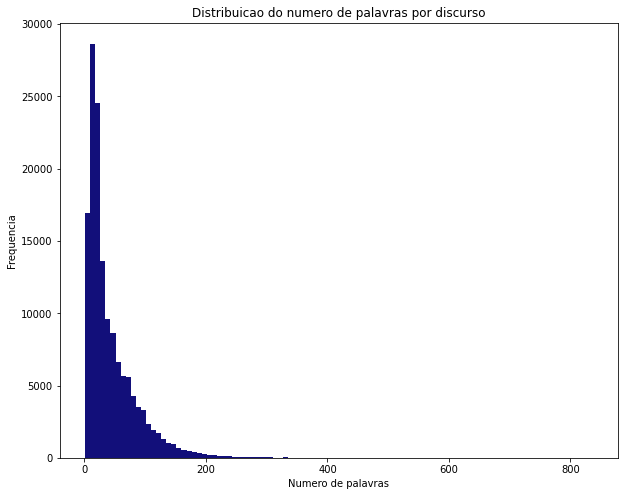

In [5]:
# plotar histograma
fig = plt.figure(figsize=(10,8))

ax1 = df.discourse_len.plot(kind='hist', color = "#120f7a", bins=100)
ax1.set_title('Distribuicao do numero de palavras por discurso')
ax1.set_xlabel("Numero de palavras")
ax1.set_ylabel("Frequencia")

# Limpeza do banco de dados

In [6]:
# Excluir discursos com mais de 200 palavras
df.drop(df.loc[df['discourse_len'] >= 200].index, inplace=True)

# tokenizacao. Aqui se cria um "dicionario" contendo todas as palavras existentes no banco de dados e um numero associado a cada palavra
# num_words seta o maximo numero de palavras a ser "tokenizada".
# Quero converter estas tokens pra binarios de 16 bits entao  num_words = 2**16 = 65,536
tokenizer = keras.preprocessing.text.Tokenizer(num_words = 2**16) 
tokenizer.fit_on_texts(df.discourse_text[:])

# checar numero total de palavras no dicionario
df_dict =tokenizer.word_index
print(len(df_dict))


56591


parece que 16 bits eh o suficiente

In [7]:
#exemplo de paragrafo tokenizado
paragraph = tokenizer.texts_to_sequences([df.iloc[5].discourse_text])
paragraph = np.asarray(paragraph).flatten()
paragraph

array([ 390,   98,  767,    3,  155,  390,  563,  100,  318,  102,   88,
        390,    3,  141,  195,  155,    2,  891,   52,   21,  163,   28,
         10,   29,   11,   61,  146, 1854,  100,  453,   43,   11,   28,
         11,  163,   14,    2, 5030,   10,   29,  390,    1,  101,   79,
         68,  255,  124,  531])

In [8]:
#convertendo de volta
tokenizer.sequences_to_texts([paragraph])

["that's why there's a thing that's called no texting while driving that's a really important thing to remember some people still do it because they think it's stupid no matter what they do they still have to obey it because that's the only way how did he save"]

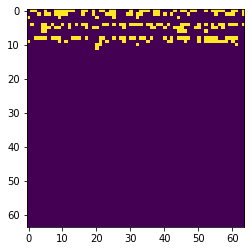

In [9]:
#funcao para converter paragrafo em imagem
def paragraph_2_img(paragraph):
    # Converte numero para vetor binario de 16 opsicoes (bits). E.g.: 
    # 4 -> [0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0]
    # 3 -> [1,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0]
    # cada vetor sera rearranjado em uma matrix/imagem 4x4 bits/pixels. E.g.:
    # 3 -> [[1,1,0,0],
    #       [0,0,0,0]
    #       [0,0,0,0]
    #       [0,0,0,0]]
    paragraph = (((paragraph[:,None] & (1 << np.arange(16)))) > 0).astype(int)
    img = np.zeros((64, 64)) #cria imagem maior para representar o paragrafo (64x64 pixels/bits).
    for iword in range(paragraph.shape[0]):
        # cada linha tera 16 palavras no maximo. Cada paragrafo tera 16 linhas no maximo.
        # eh preciso indexar 16x16 posicoes
        l = iword // 16
        c = iword % 16
        img[l*4:l*4+4,c*4:c*4+4] = paragraph[iword].reshape((4, 4))
    return img

#Exemplo
img = paragraph_2_img(paragraph)
plt.imshow(img)

# Construir banco de dados de imagens

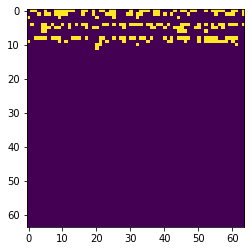

In [10]:
X = np.zeros((df.shape[0],64, 64))
for i in range(df.shape[0]):
    paragraph = tokenizer.texts_to_sequences([df.iloc[i].discourse_text])
    paragraph = np.asarray(paragraph).flatten()
    X[i,:,:] = paragraph_2_img(paragraph)
plt.imshow(X[5])

In [11]:
y = df["discourse_type"].copy()

y = y.map({'Claim': 0, 
            'Evidence': 1,
            'Position': 2,
            'Concluding Statement': 3,
            'Lead': 4,
            'Counterclaim': 5,
            'Rebuttal': 6,})

In [12]:
# dividir banco de dados em treino e teste
X_train, X_val, y_train, y_val = train_test_split(X, 
                                                    y, 
                                                    test_size=0.30,
                                                    stratify=y,
                                                    shuffle=True, random_state=0)

In [13]:
# checar tamanhos
X.shape[0], y.shape[0], X_train.shape[0], y_train.shape[0], X_val.shape[0], y_val.shape[0]

(142811, 142811, 99967, 99967, 42844, 42844)

In [14]:
# one hot encode do target
y_val_oh = tf.keras.utils.to_categorical(y_val, num_classes=7, dtype='float32')
y_train_oh = tf.keras.utils.to_categorical(y_train, num_classes=7, dtype='float32')

In [15]:
# A CNN espera um vetor 4D de entrada com shape [tamanho,64,64,1]. A ultima dimencao seria pros canais RGB, mas minhas imagens sao preto e brancas.
# Mas eh mesmo assim eh preciso criar essa dimencao:
X_train = X_train[:,:,:,None]
X_val = X_val[:,:,:,None]

# Treinamento do modelo

Aqui eu vou usar a mesma CNN usada no treinamento, a unica diferenca eh que eu criei um kernel de 4x4 pra ler as palavras (na primeira camada) e os strides tambem de 4x4. Ou seja, o kernel vai pular de palavra em palavra. Tbm tive que tirar o padding e max pool, ja que todo pixel eh importante.

In [16]:
from tensorflow.keras import layers

model = tf.keras.Sequential([

    # First Convolutional Block
    layers.Conv2D(filters=32, kernel_size=4, strides=4, activation="relu", padding='valid',
                  # [height, width, color channels(RGB)]
                  input_shape=[64, 64, 1]),
    #layers.MaxPool2D(),
    layers.Dropout(0.3),
    layers.BatchNormalization(),

    # Second Convolutional Block
    layers.Conv2D(filters=64, kernel_size=3, activation="relu", padding='same'),
    #layers.MaxPool2D(),
    layers.Dropout(0.3),
    layers.BatchNormalization(),

    # Third Convolutional Block
    layers.Conv2D(filters=128, kernel_size=3, activation="relu", padding='same'),
    #layers.MaxPool2D(),
    layers.Dropout(0.3),
    layers.BatchNormalization(),

    # Classifier Head
    layers.Flatten(),
    layers.Dense(units=128, activation="relu"),
    layers.Dense(units=7, activation="sigmoid"),
])

model.compile(
    optimizer='adam',
    loss='binary_crossentropy',
    metrics=['accuracy'],
)


User settings:

   KMP_AFFINITY=granularity=fine,noverbose,compact,1,0
   KMP_BLOCKTIME=0
   KMP_DUPLICATE_LIB_OK=True
   KMP_INIT_AT_FORK=FALSE
   KMP_SETTINGS=1
   KMP_WARNINGS=0

Effective settings:

   KMP_ABORT_DELAY=0
   KMP_ADAPTIVE_LOCK_PROPS='1,1024'
   KMP_ALIGN_ALLOC=64
   KMP_ALL_THREADPRIVATE=128
   KMP_ATOMIC_MODE=2
   KMP_BLOCKTIME=0
   KMP_CPUINFO_FILE: value is not defined
   KMP_DETERMINISTIC_REDUCTION=false
   KMP_DEVICE_THREAD_LIMIT=2147483647
   KMP_DISP_NUM_BUFFERS=7
   KMP_DUPLICATE_LIB_OK=true
   KMP_ENABLE_TASK_THROTTLING=true
   KMP_FORCE_REDUCTION: value is not defined
   KMP_FOREIGN_THREADS_THREADPRIVATE=true
   KMP_FORKJOIN_BARRIER='2,2'
   KMP_FORKJOIN_BARRIER_PATTERN='hyper,hyper'
   KMP_GTID_MODE=3
   KMP_HANDLE_SIGNALS=false
   KMP_HOT_TEAMS_MAX_LEVEL=1
   KMP_HOT_TEAMS_MODE=0
   KMP_INIT_AT_FORK=true
   KMP_LIBRARY=throughput
   KMP_LOCK_KIND=queuing
   KMP_MALLOC_POOL_INCR=1M
   KMP_NUM_LOCKS_IN_BLOCK=1
   KMP_PLAIN_BARRIER='2,2'
   KMP_PLAIN_BARRIER

In [17]:
from tensorflow.keras.callbacks import EarlyStopping

early_stopping = EarlyStopping(
    min_delta=0, # minimium amount of change to count as an improvement
    patience=10, # how many epochs to wait before stopping
    restore_best_weights=True,
)

In [18]:
history = model.fit(
    X_train, y_train_oh,
    validation_data=(X_val, y_val_oh),
    batch_size=256,
    epochs=50,
    callbacks=[early_stopping],
)

2022-02-08 19:21:17.896199: I tensorflow/compiler/mlir/mlir_graph_optimization_pass.cc:185] None of the MLIR Optimization Passes are enabled (registered 2)


Epoch 1/50
391/391 [==============================] - 201s 510ms/step - loss: 0.2957 - accuracy: 0.5779 - val_loss: 1.7616 - val_accuracy: 0.2176
Epoch 2/50
391/391 [==============================] - 199s 509ms/step - loss: 0.2617 - accuracy: 0.6106 - val_loss: 0.2652 - val_accuracy: 0.6112
Epoch 3/50
391/391 [==============================] - 200s 513ms/step - loss: 0.2501 - accuracy: 0.6294 - val_loss: 0.2593 - val_accuracy: 0.6031
Epoch 4/50
391/391 [==============================] - 200s 510ms/step - loss: 0.2427 - accuracy: 0.6406 - val_loss: 0.2482 - val_accuracy: 0.6314
Epoch 5/50
391/391 [==============================] - 201s 515ms/step - loss: 0.2375 - accuracy: 0.6492 - val_loss: 0.2330 - val_accuracy: 0.6597
Epoch 6/50
391/391 [==============================] - 200s 512ms/step - loss: 0.2336 - accuracy: 0.6532 - val_loss: 0.2363 - val_accuracy: 0.6601
Epoch 7/50
391/391 [==============================] - 202s 516ms/step - loss: 0.2301 - accuracy: 0.6599 - val_loss: 0.2321 -

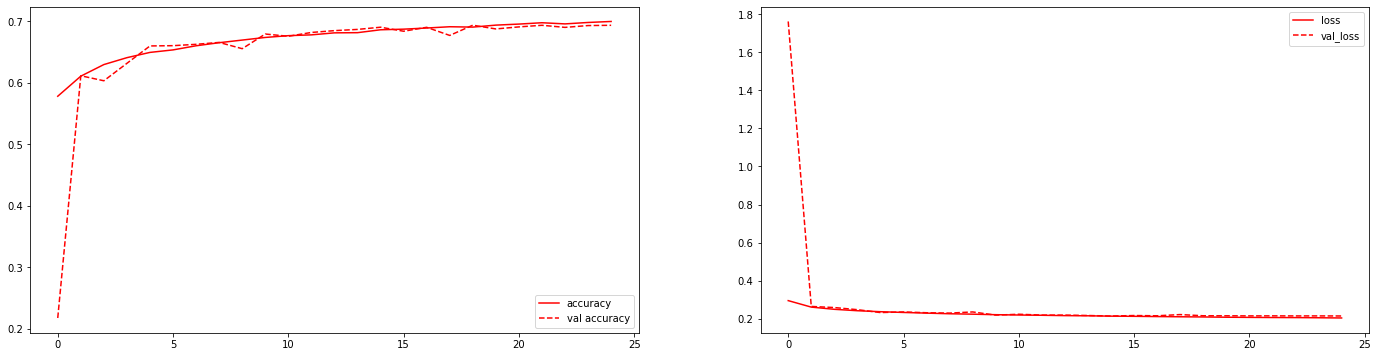

In [19]:
history_frame = pd.DataFrame(history.history)


plt.figure(figsize=(24, 6))
plt.subplot(1, 2, 1)
plt.plot(history_frame.index,history_frame.accuracy,'r-',label='accuracy')
plt.plot(history_frame.index,history_frame.val_accuracy,'r--',label='val accuracy')
plt.legend(loc='lower right')

plt.subplot(1, 2, 2)
plt.plot(history_frame.index,history_frame.loss,'r-',label='loss')
plt.plot(history_frame.index,history_frame.val_loss,'r--',label='val_loss')
plt.legend(loc='upper right')

plt.show()

In [20]:
model.save("baseline.h5")

In [21]:
model = keras.models.load_model("./baseline.h5")

# Submissao

Ate aqui foi meio caminho andado. Agora resta achar uma forma de seccionar as redacoes do banco de dados de teste. Estou pensando em treinar outra CNN pra isso.. mas se alguem tiver uma sugestao favor postar la no grupo!